In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# All imports go here

## On commence par implémenter les fonctions dont on aura besoin dans l'algorithme du SVGD

In [2]:
def grad1d(f,x,h): # dérivée par la méthode des différences finies
    return (1/h)*(f(x+h)-f(x))

def grad(F,x,h): # Gradient en multidimension
    try:
        d = len(x)
    except:
        d=1 # dimension d'un vecteur
    G = []
    for i in range(d):
        hi = np.array([0]*d,dtype=float)
        hi[i] = h
        g = (1/h)*(F(x+hi)-F(x)) # la ieme dérivée partielle
        G.append(g)
    return np.array(G)

def k(x,y,sigma): # RBF kernel (gaussian)
    return np.exp(-(1/2*sigma**2)*np.inner(x-y,x-y)) 

def grad2_k(x,y,sigma): # Gradient du RBF par rapport a x
    return (-1/sigma**2)*k(x,y,sigma)*(x-y)

### Test des fonctions de calcul de gradient (comparaison entre les valeurs théoriques et numériques)

In [3]:
# Test de la fonction gradient
def F(x):
    return k(x,0,1)

# Il faut trouver que grad = grad2_k à peu près
h = 1e-10
x = np.array([1,2])
G = grad(F,x,h)
gk = grad2_k(x,0,1)
print(G)
print(gk)
print("Bonne approximation !")

[-0.08208503 -0.16417007]
[-0.082085 -0.16417 ]
Bonne approximation !


## Maintenant qu'on a tout ce qu'il faut pour implémenter l'algorithme du SVGD
Les paramètres de la fonctions SVGD sont:
- V : la fonction potentiel de la distribution cible
- X: matrix de taille Nxd (N lignes et d colonnes) telle que chaque ligne contient un de nos vecteurs
- h: pour le calcul du gradient
- maxit: le nombre maximum d'itérations avant de s'arrêter (il est de l'ordre de grandeur de $O(\frac{d^{\frac{3}{2}}}{\epsilon})$) mais on le fixe au début.
- lam : learning rate
- sigma: parameter in the RBF kernel


In [5]:
def SVGD(V,X,h,lam,sigma,maxit=150): 
    #trajectory = []
    #trajectory.append(list(X))  
    Xf = X.copy() # la configuration finale
    t=0 # le nombre d'itérations de l'algorithme
    converged = False # on converge lorsque le déplacement devient moins de eps
    N = len(X)
    try:
        d = len(X[0])
    except:
        d=1
    #maxit = int(d**2/eps) 
    X0 = Xf.copy()
    while t<maxit:
        t+=1
        for i in range(N): # update data
            s = 0
            for j in range(N):
                s += grad(V,Xf[j],h)*k(Xf[i],Xf[j],sigma) - grad2_k(Xf[j],Xf[i],sigma)
            Xf[i] = Xf[i] -(lam/N)*s
    #trajectory.append(list(Xf))
    return Xf


## Test de l'algorithme en dimension d=1:
- On va commencer par génerer des des vecteurs suivant une loi uniforme
- On va essayer de les faire converger vers une loi normale. 

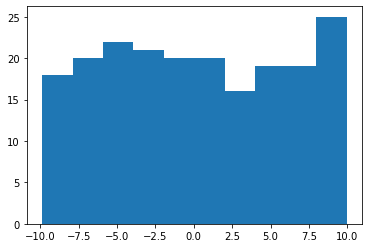

In [6]:
def genData(N,d):
    x = []
    for i in range(N):
        x.append(np.random.uniform(low=-10.0,high=10.0, size=d))
    return np.array(x)

def tar(x): # The F for a normal distribution of mean 2 and sd 1
    return (1/2)*np.inner(x-2.0,x-2.0)

X = genData(200,1)
h = 1e-10
lam=1
sigma=1
maxit=150
plt.hist(X)

plt.show()

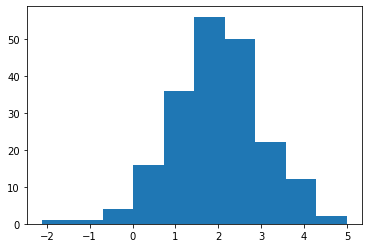

In [7]:
xf = SVGD(tar,X,h,lam,sigma,maxit) # expected time : 2m30s max
plt.hist(xf)
plt.show()

### We will plot here a kernel density estimate (KDE), which approximates the density of probability of distribution of some data

<AxesSubplot:ylabel='Density'>

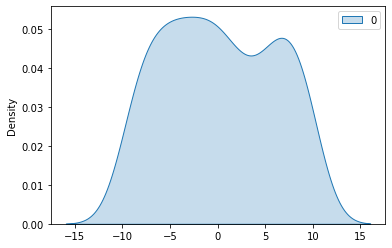

In [9]:
# Density for our uniform data
sns.kdeplot(data=X, fill=True)


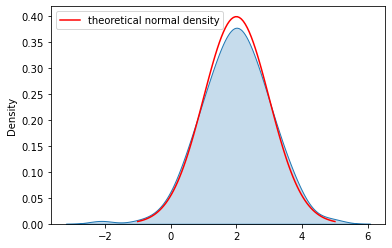

In [10]:
# Now the density of particles obtaned by applying SVGD to them
sns.kdeplot(data=xf, fill=True)
t = np.linspace(-1,5,100)

def normal_21(x):
    return (1/(np.sqrt(2*np.pi)))*np.exp(-(1/2)*(x-2)**2)
  
y = normal_21(t)
plt.plot(t,y,color="red",label="theoretical normal density")
plt.legend()
plt.show()

## Dimension 2:

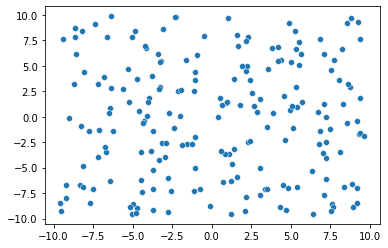

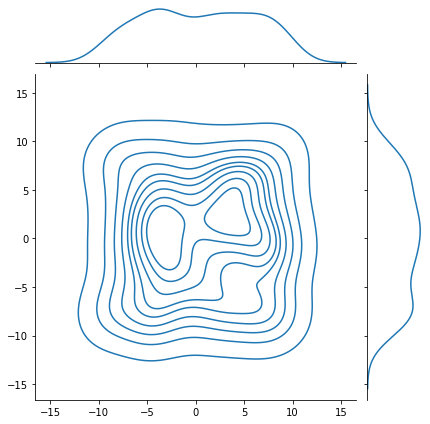

In [ ]:
X2 = genData(200,2) 
sns.scatterplot(x=X2.transpose()[0], y=X2.transpose()[1])
sns.jointplot(x = X2.transpose()[0], y=X2.transpose()[1], kind='kde') # for the uniform

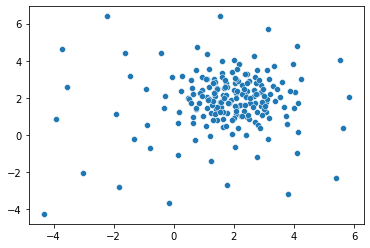

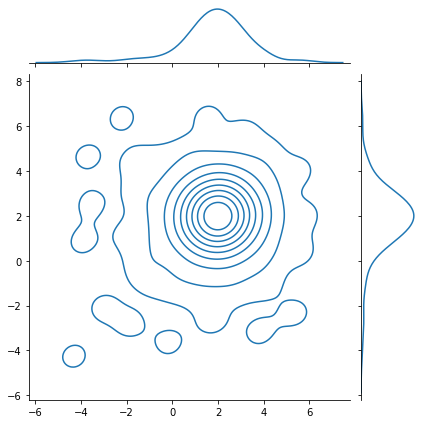

In [ ]:
# Now the particles obtained using SVGD
xf = SVGD(tar,X2,h,lam,sigma,100) # computation time: 2m47s avec 150 c'est 4m35
sns.scatterplot(x=xf.transpose()[0],y=xf.transpose()[1] )
sns.jointplot(x = xf.transpose()[0], y=xf.transpose()[1], kind='kde')


## Gaussian mixture

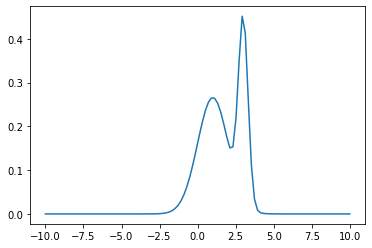

In [22]:
def gauss(x,mean,sigma):
    return (1/(np.sqrt(2*np.pi*sigma**2)))*np.exp(-1/(2*sigma**2)*(x-mean)**2)

def mix_gauss(x, mean1, mean2, sigma1,sigma2): # somme de normal N(1,2) et N(1.5,0.5)
    return (2/3)*gauss(x,mean1,sigma1) + (1/3)*gauss(x,mean2,sigma2)

mean1 = 1
mean2 = 3
sigma1 = 1
sigma2 = np.sqrt(0.1)
x = np.linspace(-10,10,100)
y = mix_gauss(x,mean1,mean2,sigma1,sigma2)
plt.plot(x,y)
plt.show()


In [23]:
# Gaussian mixture target potential
def tar2(x): 
    return -np.log(mix_gauss(x,mean1,mean2,sigma1,sigma2))


In [ ]:
# Simulation of SVGD for Gaussian mixture
xf = SVGD(tar2,X,h,1,1,200) # time : 27m12s for 500 iterations
sns.kdeplot(data=xf, fill=True)


(array([ 1.,  4.,  8., 23., 30., 33., 20., 38., 40.,  3.]),
 array([-2.24942669, -1.59983851, -0.95025034, -0.30066216,  0.34892601,
         0.99851419,  1.64810236,  2.29769054,  2.94727871,  3.59686689,
         4.24645506]),
 <a list of 10 Patch objects>)

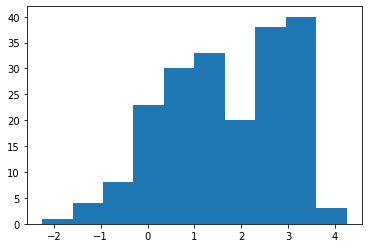

In [ ]:
plt.hist(xf)

## Commentaire:

L'algorithme permet d'estimer bien les moyennes des deux gaussiennes, mais il ne peut pas estimer les variances de chacune des deux, ni le nombre d'éléments pour chacune.

## Comparison to Langevin method:

In [ ]:
def LA(x0,F,h,N): # ht est dans l'algo de Langevin, et h pour le gradient, N is the number of particles that we want at the end
    xf = x0
    t = 0
    maxit = 20000
    try:
        d = len(x0)
    except:
        d=1
    l = [] # list of realisations of Langevin
    for i in range(N):
        xf = x0
        while t<maxit: # Gradient descent
            xi = np.random.normal(loc = 0, scale = 1)
            t+=1
            ht = np.
            xf = xf - ht*grad1d(F,xf,h) + np.sqrt(2*ht)*xi
        l.append(xf)

    return np.array(l)


## Test of the algorithm on tar2

In [ ]:
x0 = np.random.uniform(low=-10,high = 10)
h = 1e-10
N = 200
x0

-2.275973785269107

200


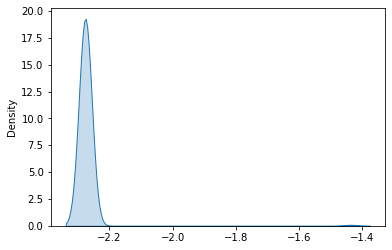

In [ ]:
ht = 0.1
def tar3(x):
    return -np.log(gauss(x,2,1))

xf = LA(x0,tar3,h, N) # time : environ 1 min
print(len(xf))
sns.kdeplot(data=xf,shade=True)

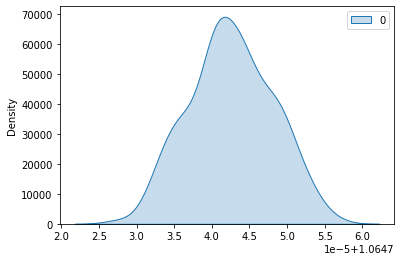

In [ ]:


xf = LA(X,ht,tar2,h) # time : rapide: quelques secondes
sns.kdeplot(data=xf,shade=True)

# Schémas pour l'état de l'art

## Gradient descent scheme:

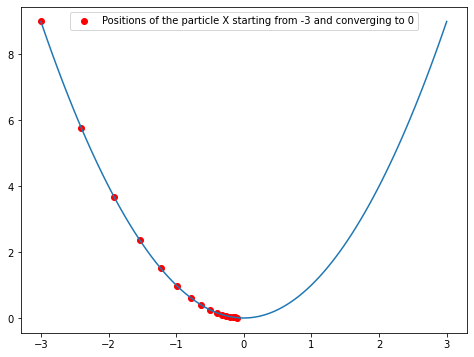

In [15]:
def f(x):
    return x**2

def gf(x):
    return 2*x
def desc(grad,gamma,x0, n):
    x = x0
    l = [x0]
    for i in range(n):
        x = x-gamma*grad(x)
        l.append(x)
    return np.array(l)

x0 = -3.
gamma = 0.1
n = 15
t = np.linspace(-3,3,100)
l = desc(gf,gamma,x0,n)
plt.figure(figsize=(8,6))
plt.plot(t, f(t))
plt.scatter(l,f(l), c='r', label='Positions of the particle X starting from -3 and converging to 0')
plt.legend()
plt.show()

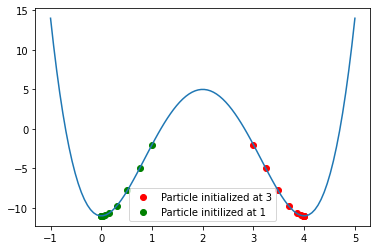

In [16]:
def F(x):
    return (x-2)**4 - 8*(x-2)**2 + 5

def grF(x):
    return 4*(x-2)**3 -16*(x-2)

t = np.linspace(-1,5,100)
gamma = 0.02
n = 10
x1 = 3
x2 = 1

l1 = desc(grF,gamma,x1,n)
l2 = desc(grF,gamma,x2,n)
plt.scatter(l1,F(l1),c='r',label='Particle initialized at 3')
plt.scatter(l2,F(l2),c='g',label='Particle initilized at 1')
plt.legend()
plt.plot(t,F(t))
plt.show()

# Session 2: 

## Première approche: Mettre du bruit dans SVGD

On va alors définir une nouvelle fonction qui s'appelle **svgd_bruit** dans laquelle on ajoute du bruit à chaque update.

Au début, on va essayer d'ajouter un bruit gaussien $ \mathcal{N}(0, b^2)$ et ensuite analyser les résultats.


In [18]:
# Define the SVGD method with Gaussian noise

def SVGD_bruit(V, X, h, lam, sigma, b, maxit=150) : 
    # b is the standard deviation 
    #trajectory = []
    #trajectory.append(list(X))  
    Xf = X.copy() # la configuration finale
    t=0 # le nombre d'itérations de l'algorithme
    N = len(X)
    try:
        d = len(X[0])
    except:
        d=1
    #maxit = int(d**2/eps) 
    X0 = Xf.copy()
    while t<maxit:
        t+=1
        for i in range(N): # update data
            s = 0
            for j in range(N):
                xi = np.random.normal(loc = 0, scale = b)
                s += grad(V,Xf[j],h)*k(Xf[i],Xf[j],sigma) - grad2_k(Xf[j],Xf[i],sigma) + xi
            Xf[i] = Xf[i] -(lam/N)*s
    #trajectory.append(list(Xf))
    return Xf


### Simulation

On teste cette approche, et on essaye de converger vers la loi $\mathcal{N}(2,1)$

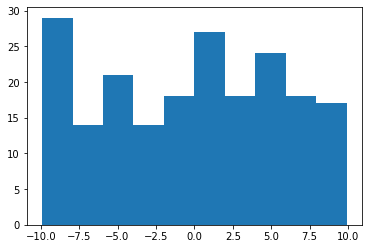

In [19]:
# Generating uniform variables
X = genData(200,1)
h = 1e-10
lam=1
sigma=1
maxit=150
plt.hist(X)

plt.show()

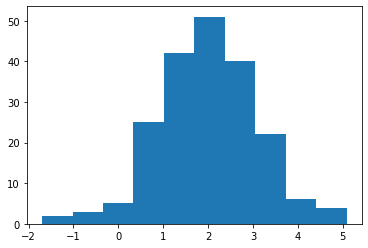

In [30]:
# Applying SVGD with noise to these variables

# standard deviation of the noise
b = 2

# Simulation
xf = SVGD_bruit(tar, X, h, lam, sigma, b, maxit) # expected time : 2m30s max
plt.hist(xf)
plt.show()

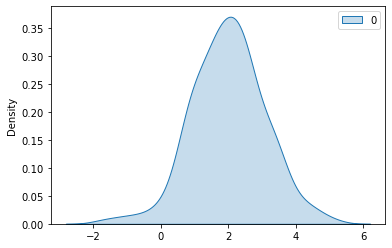

In [31]:
# Visualizing the density with seaborn
sns.kdeplot(data=xf, fill=True)
t = np.linspace(-1,5,100)


### Test with Gaussian mixture:

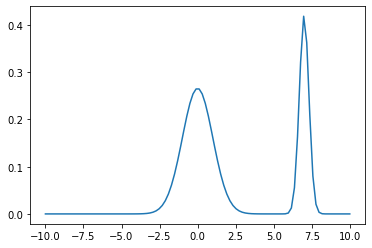

In [32]:
# Visualizing the target distribution
mean1 = 0
mean2 = 7
sigma1 = 1
sigma2 = np.sqrt(0.1)
x = np.linspace(-10,10,100)
y = mix_gauss(x,mean1,mean2,sigma1,sigma2)
plt.plot(x,y)
plt.show()


<AxesSubplot:ylabel='Density'>

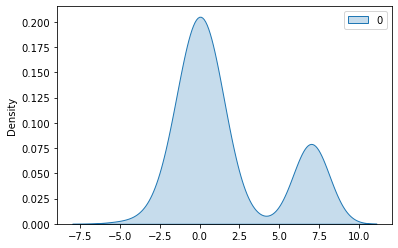

In [33]:
# Gauss mixture
xf = SVGD_bruit(tar2, X, h, lam, sigma, b, 200) # time : 27m12s for 500 iterations
sns.kdeplot(data=xf, fill=True)


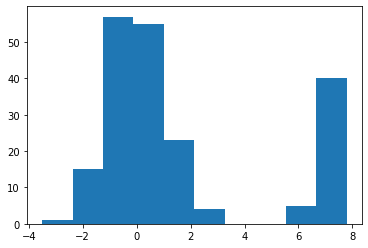

In [28]:
# Histograms
plt.hist(xf)
plt.show()